In [1]:
!pip install tenseal
!pip install openvino-dev
!pip install onnx onnxruntime
!pip show tenseal openvino-dev
!pip install kaggle  # Install the Kaggle API client
!pip install python-snappy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00
Name: tenseal
Version: 0.3.15
Summary: A Library for Homomorphic Encryption Operations on Tensors
Home-page: https://github.com/OpenMined/TenSEAL
Author: OpenMined
Author-email: info@openmined.org
License: Apache-2

In [3]:
import hashlib
import snappy

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

100%|██████████| 652k/652k [00:00<00:00, 107MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2


In [5]:
import os
import time
import pandas as pd
import torch
import torch.nn as nn
import tenseal as ts
from openvino.runtime import Core
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim # Import the optim module

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Initialization of Encryption
def init_encryption():
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

In [7]:
# Dataset Loading and Preprocessing
def load_and_preprocess_data(dataset_path):
    data = pd.read_csv(dataset_path)
    data = data.apply(lambda x: x.fillna(x.mode()[0]), axis=0)
    label_encoders = {}
    categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    X = data.drop(columns=['income'])
    y = data['income'].map({'<=50K': 0, '>50K': 1})
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y


In [8]:
# Neural Network Model Definition
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [9]:
# Model Training
def train_model(model, X_train, y_train, epochs=10, batch_size=32):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i + batch_size]
            labels = y_train[i:i + batch_size]
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / (len(X_train) // batch_size)
        losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")
    return losses

In [10]:
# Benchmarking Function
def benchmark_model(model, X_test, y_test, context):
    core = Core()
    torch.onnx.export(model, torch.randn(1, X_test.shape[1]), "model.onnx", opset_version=11)
    model_ir = core.read_model("model.onnx")
    compiled_model = core.compile_model(model_ir, "CPU")
    correct = 0
    total = 0
    start_time = time.time()
    latencies = []
    for i in range(len(X_test)):
        sample_start = time.time()
        encrypted_input = ts.ckks_vector(context, X_test[i].tolist())
        decrypted_input = encrypted_input.decrypt()
        input_tensor = torch.tensor(decrypted_input).unsqueeze(0)
        prediction = compiled_model([input_tensor])
        sample_latency = time.time() - sample_start
        latencies.append(sample_latency)
        total += 1
        # Access y_test using iloc to get the value by position
        if (prediction[0] > 0.5 and y_test.iloc[i] == 1) or (prediction[0] <= 0.5 and y_test.iloc[i] == 0):
            correct += 1
    accuracy = correct / total * 100
    avg_latency = sum(latencies) / total
    return accuracy, avg_latency, latencies

In [11]:
# Visualization Functions
def plot_loss(losses):
    plt.figure()
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def plot_latency(latencies):
    plt.figure()
    plt.plot(range(1, len(latencies) + 1), latencies, marker='o', label="Latency per Sample")
    plt.title("Inference Latency per Sample")
    plt.xlabel("Sample")
    plt.ylabel("Latency (seconds)")
    plt.legend()
    plt.grid()
    plt.show()

Epoch [1/10], Loss: 0.3803
Epoch [2/10], Loss: 0.3299
Epoch [3/10], Loss: 0.3267
Epoch [4/10], Loss: 0.3251
Epoch [5/10], Loss: 0.3240
Epoch [6/10], Loss: 0.3230
Epoch [7/10], Loss: 0.3221
Epoch [8/10], Loss: 0.3213
Epoch [9/10], Loss: 0.3206
Epoch [10/10], Loss: 0.3200
Inference Accuracy: 85.00%
Average Latency per Sample: 0.0084 seconds


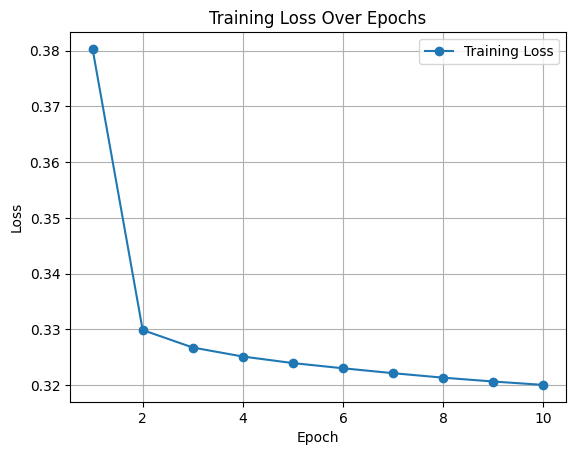

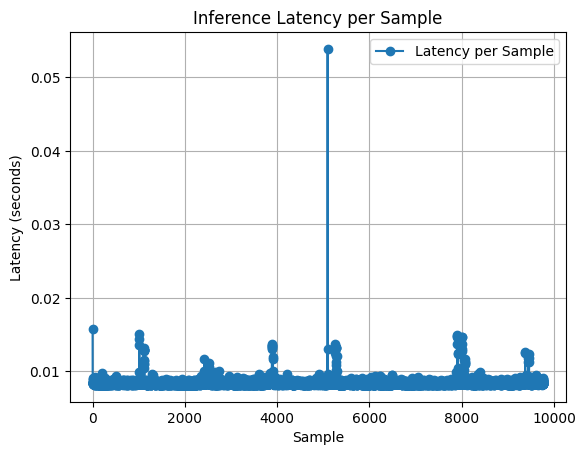

In [12]:
# Main Execution
if __name__ == "__main__":
    dataset_path = "/root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2/adult.csv"
    X, y = load_and_preprocess_data(dataset_path)
    context = init_encryption()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    model = SimpleNN(X.shape[1])
    losses = train_model(model, X_train_tensor, y_train_tensor)
    accuracy, avg_latency, latencies = benchmark_model(model, X_test, y_test, context)
    print(f"Inference Accuracy: {accuracy:.2f}%")
    print(f"Average Latency per Sample: {avg_latency:.4f} seconds")
    plot_loss(losses)
    plot_latency(latencies)



In [13]:
!apt-get update
!apt-get install -y cmake g++
!pip install pybind11
!git clone https://github.com/microsoft/SEAL.git
%cd SEAL
!cmake -S . -B build -DSEAL_BUILD_PYTHON=ON
!cmake --build build
!cmake --install build

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,199 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,588 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [45.2 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,227 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.

In [14]:
# KNN Experiment
data = pd.read_csv("/root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2/adult.csv")
data.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [15]:
print(data.shape)


(48842, 15)


In [16]:
data.isin(['?']).sum()


,0
age,0
workclass,2799
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,2809
relationship,0
race,0
gender,0


In [17]:
data['workclass']=data['workclass'].replace('?',np.nan)
data['occupation']=data['occupation'].replace('?',np.nan)
data['native-country']=data['native-country'].replace('?',np.nan)

In [18]:
info = pd.DataFrame(data.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",data.isna().sum(),True)
info.insert(2,"Duplicate",data.duplicated().sum(),True)
info.insert(3,"Unique",data.nunique(),True)

In [19]:
# Remove or modify the min and max calculations
# info.insert(4,"Min",data.min(),True)  # This line was causing the error
# info.insert(5,"Max",data.max(),True)  # This line might cause a similar error
# Instead, calculate min/max for numeric columns only
numeric_cols = data.select_dtypes(include=['number']).columns
info.insert(4, "Min", data[numeric_cols].min(), True)
info.insert(5, "Max", data[numeric_cols].max(), True)
info.T

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
IsNull,0.0,2799.0,0.0,0.0,0.0,0.0,2809.0,0.0,0.0,0.0,0.0,0.0,0.0,857.0,0.0
IsNa,0.0,2799.0,0.0,0.0,0.0,0.0,2809.0,0.0,0.0,0.0,0.0,0.0,0.0,857.0,0.0
Duplicate,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0
Unique,74.0,8.0,28523.0,16.0,16.0,7.0,14.0,6.0,5.0,2.0,123.0,99.0,96.0,41.0,2.0
Min,17.0,NaN,12285.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN
Max,90.0,NaN,1490400.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,99999.0,4356.0,99.0,NaN,NaN


In [20]:
df = data.copy()

In [21]:
df.dropna(how='any',inplace=True)
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [22]:
df.shape


(45222, 15)

In [23]:
df = df.drop_duplicates()
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [24]:
df['education'].unique()

array(['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th',
       'Prof-school', '7th-8th', 'Bachelors', 'Masters', '5th-6th',
       'Assoc-voc', '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'],
      dtype=object)

Text(0.5, 1.0, 'Histogram')

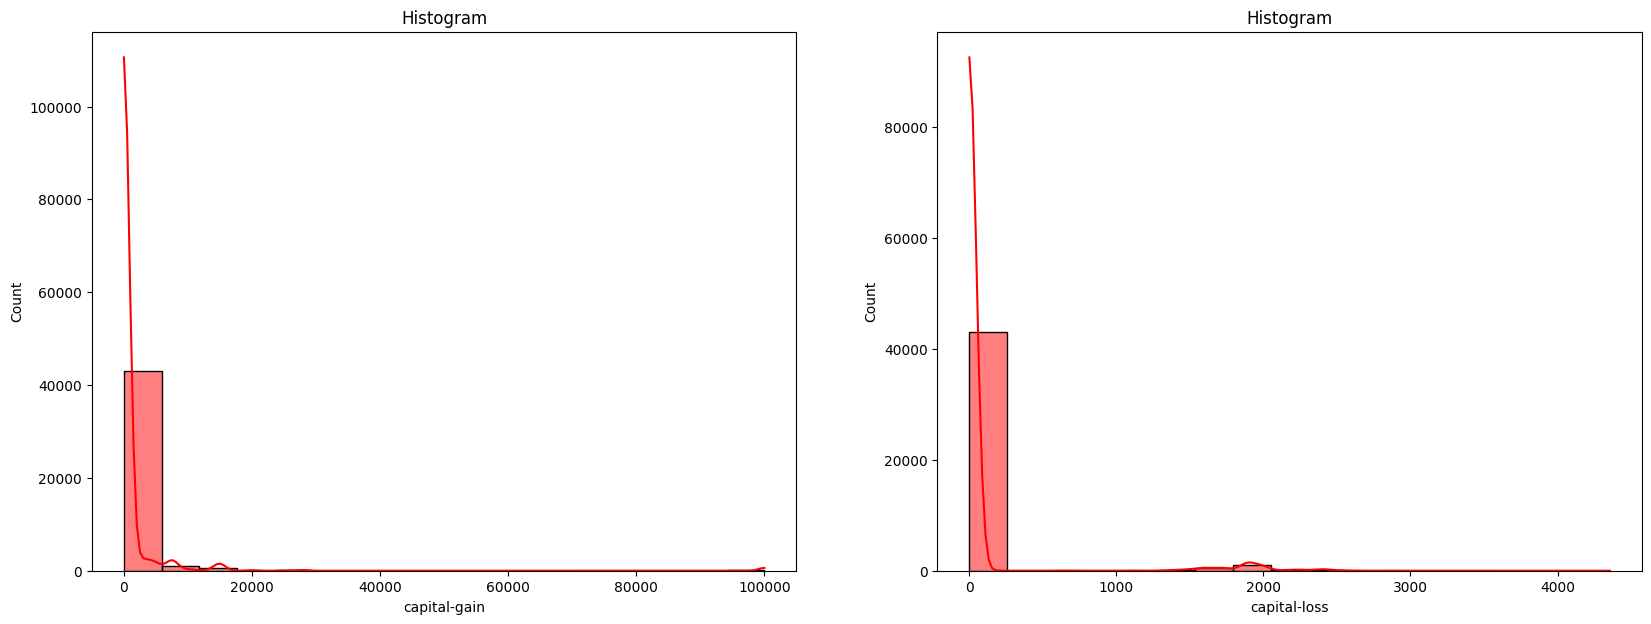

In [25]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.histplot(df['capital-gain'], kde = True,color='r')
plt.title('Histogram')
plt.subplot(1, 2, 2)
sns.histplot(df['capital-loss'], kde = True,color='r')
plt.title('Histogram')

In [26]:
df1 = df.drop(['educational-num', 'capital-gain', 'capital-loss'], axis=1)


In [27]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df1['gender'] = label_encoder.fit_transform(df1['gender'])
df1['workclass'] = label_encoder.fit_transform(df1['workclass'])
df1['education'] = label_encoder.fit_transform(df1['education'])
df1['marital-status'] = label_encoder.fit_transform(df1['marital-status'])
df1['occupation'] = label_encoder.fit_transform(df1['occupation'])
df1['relationship'] = label_encoder.fit_transform(df1['relationship'])
df1['race'] = label_encoder.fit_transform(df1['race'])
df1['native-country'] = label_encoder.fit_transform(df1['native-country'])
df1['income'] = label_encoder.fit_transform(df1['income'])

In [28]:
df1 = df.drop(['educational-num', 'capital-gain', 'capital-loss'], axis=1)

In [29]:
from sklearn import preprocessing

In [30]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


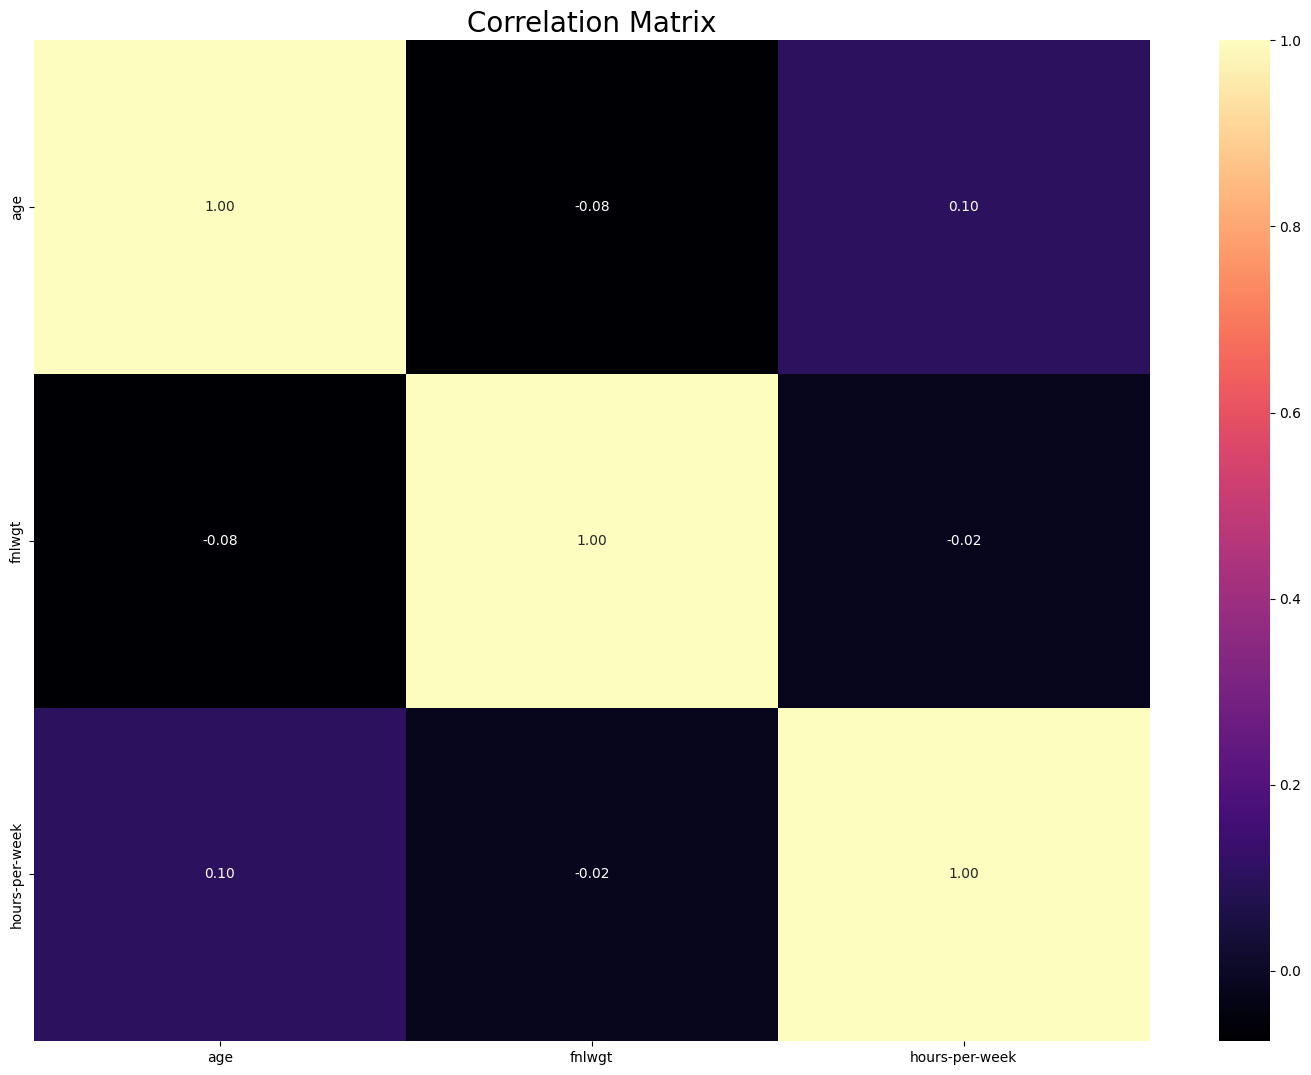

In [31]:
# Check For Missing Values
info = pd.DataFrame(df1.isnull().sum(),columns=["IsNull"])
info.insert(1,"IsNa",df1.isna().sum(),True)
info.insert(2,"Duplicate",df1.duplicated().sum(),True)
info.insert(3,"Unique",df1.nunique(),True)
# Remove or modify the min and max calculations
# info.insert(4,"Min",df1.min(),True)  # This line was causing the error
# info.insert(5,"Max",df1.max(),True)  # This line might cause a similar error
# Instead, calculate min/max for numeric columns only
numeric_cols = df1.select_dtypes(include=['number']).columns
info.insert(4, "Min", df1[numeric_cols].min(), True)
info.insert(5, "Max", df1[numeric_cols].max(), True)
info.T
# Correlation matrix
# Select only numeric features before calculating correlation
numeric_df1 = df1.select_dtypes(include=np.number)
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(numeric_df1.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [32]:
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], kde = True,color='r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')


    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')

    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)
    plt.title('Barplot')


    plt.show()

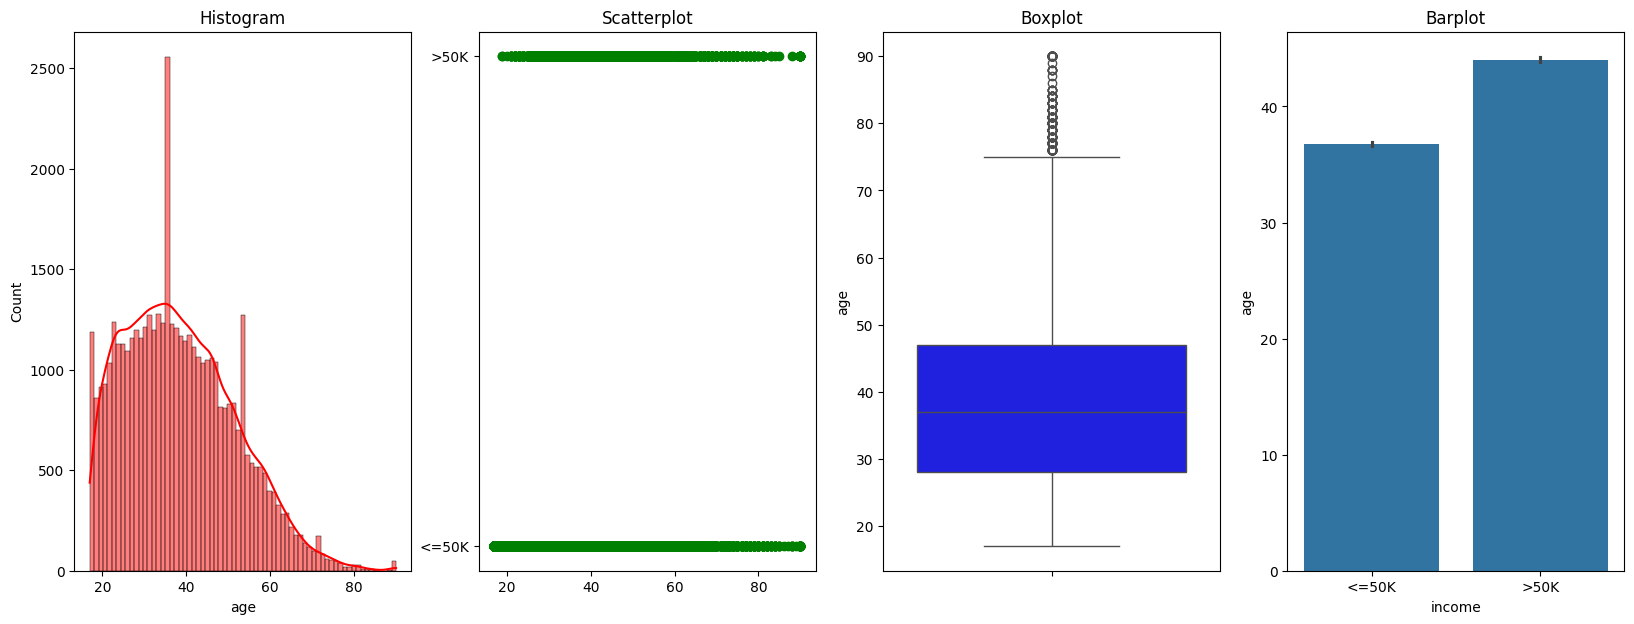

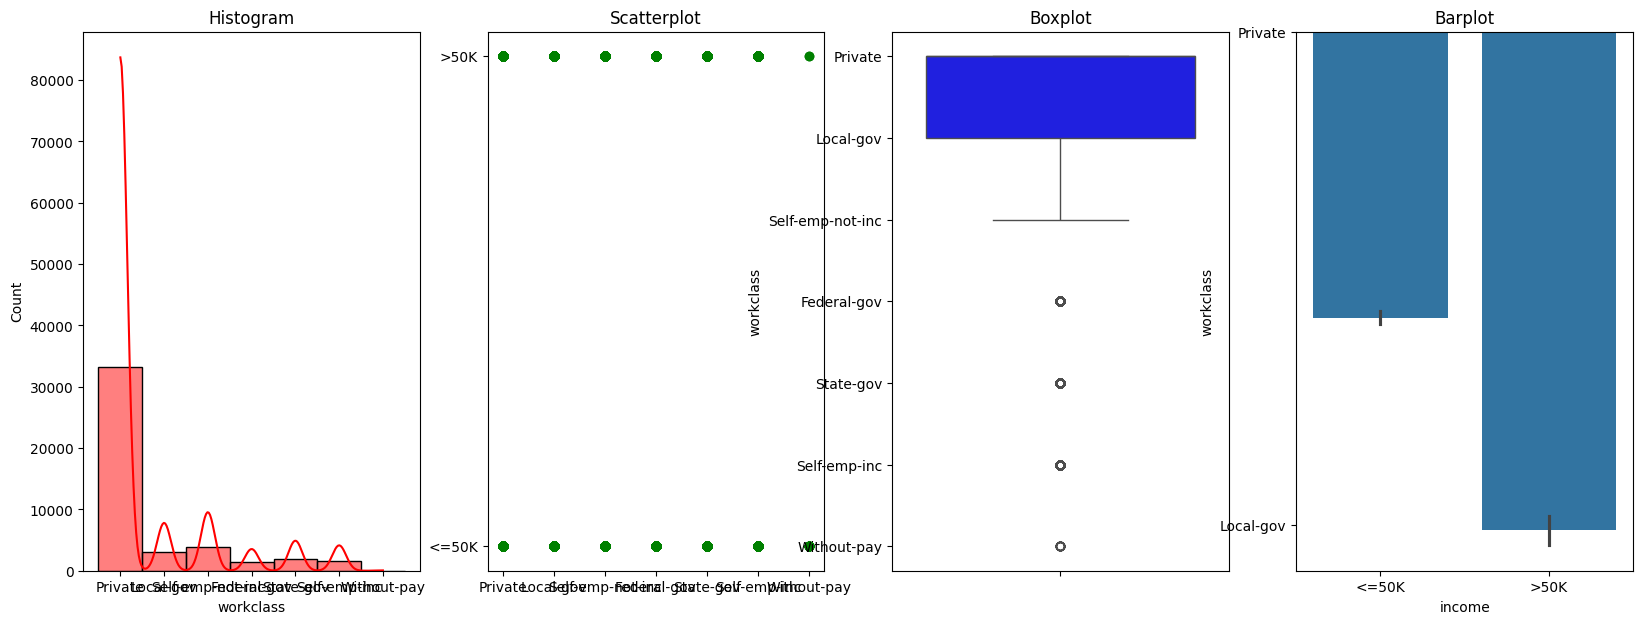

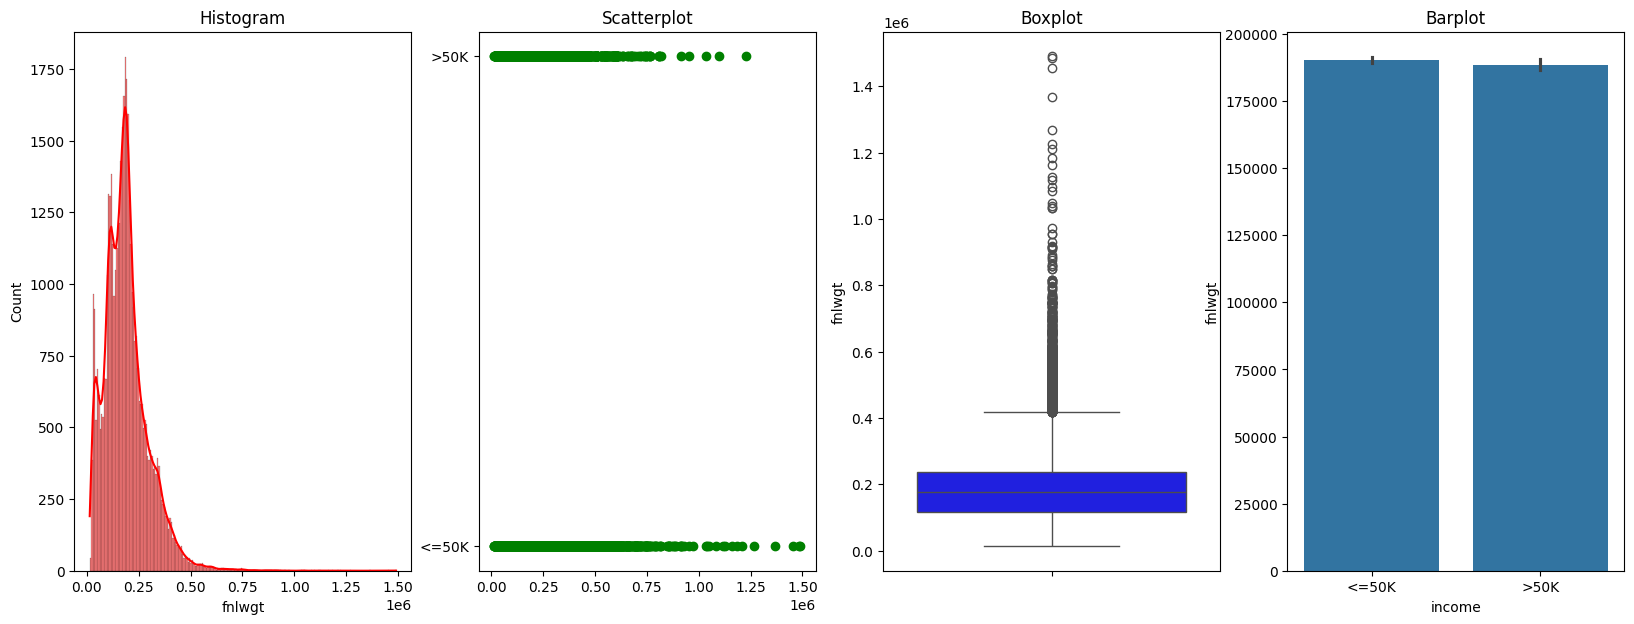

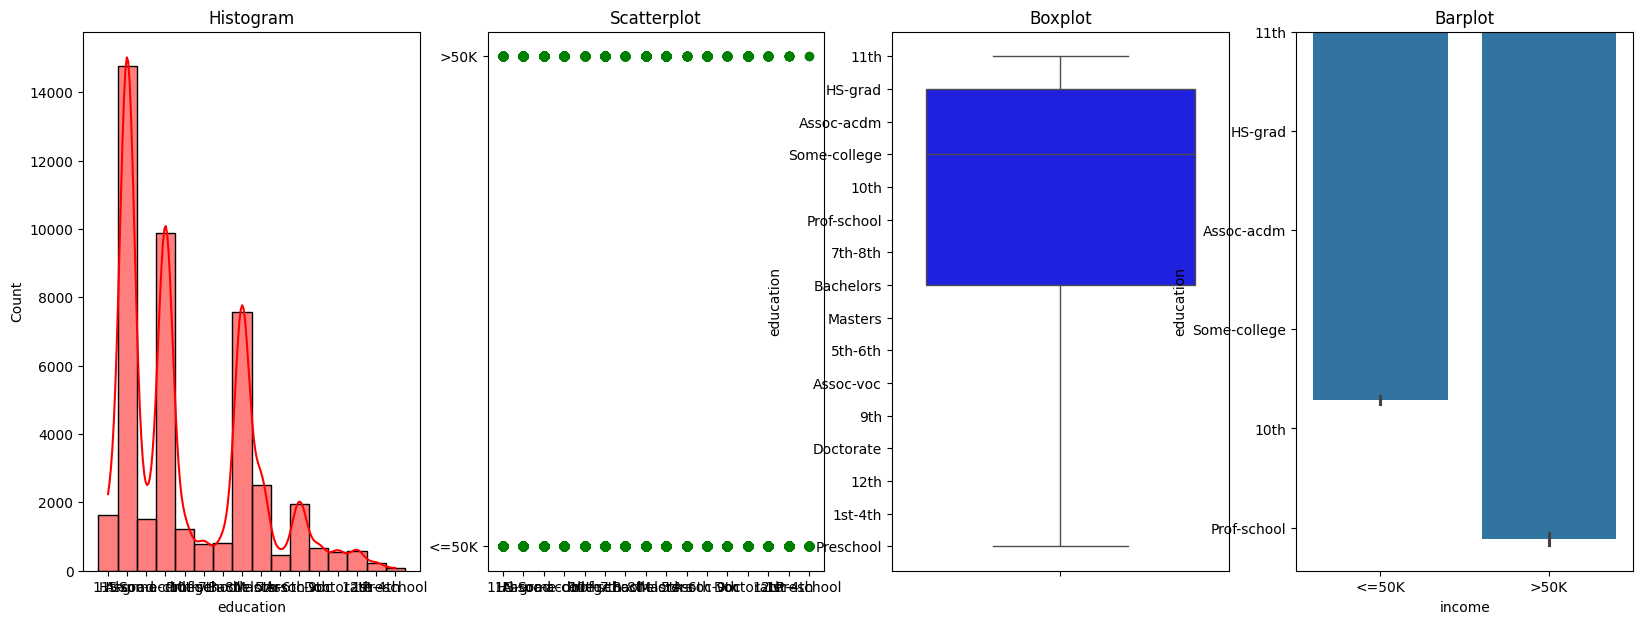

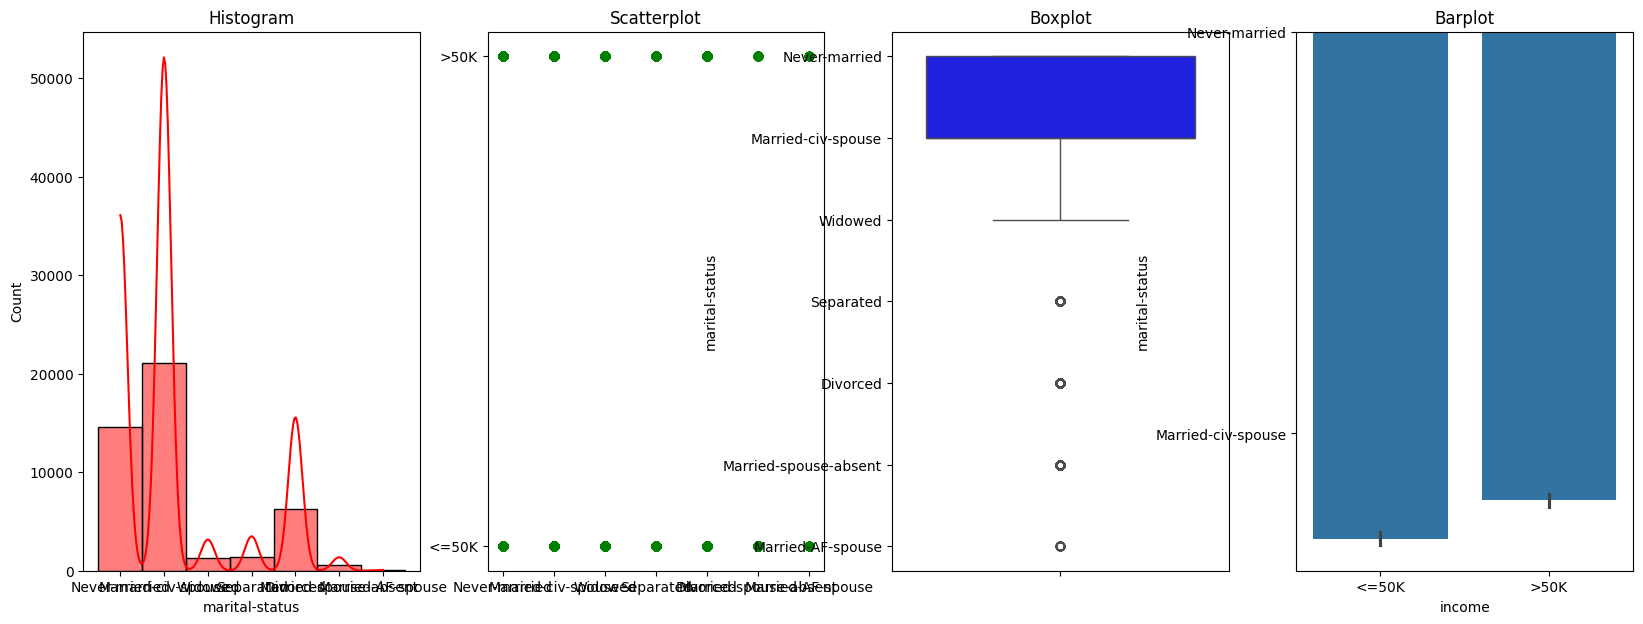

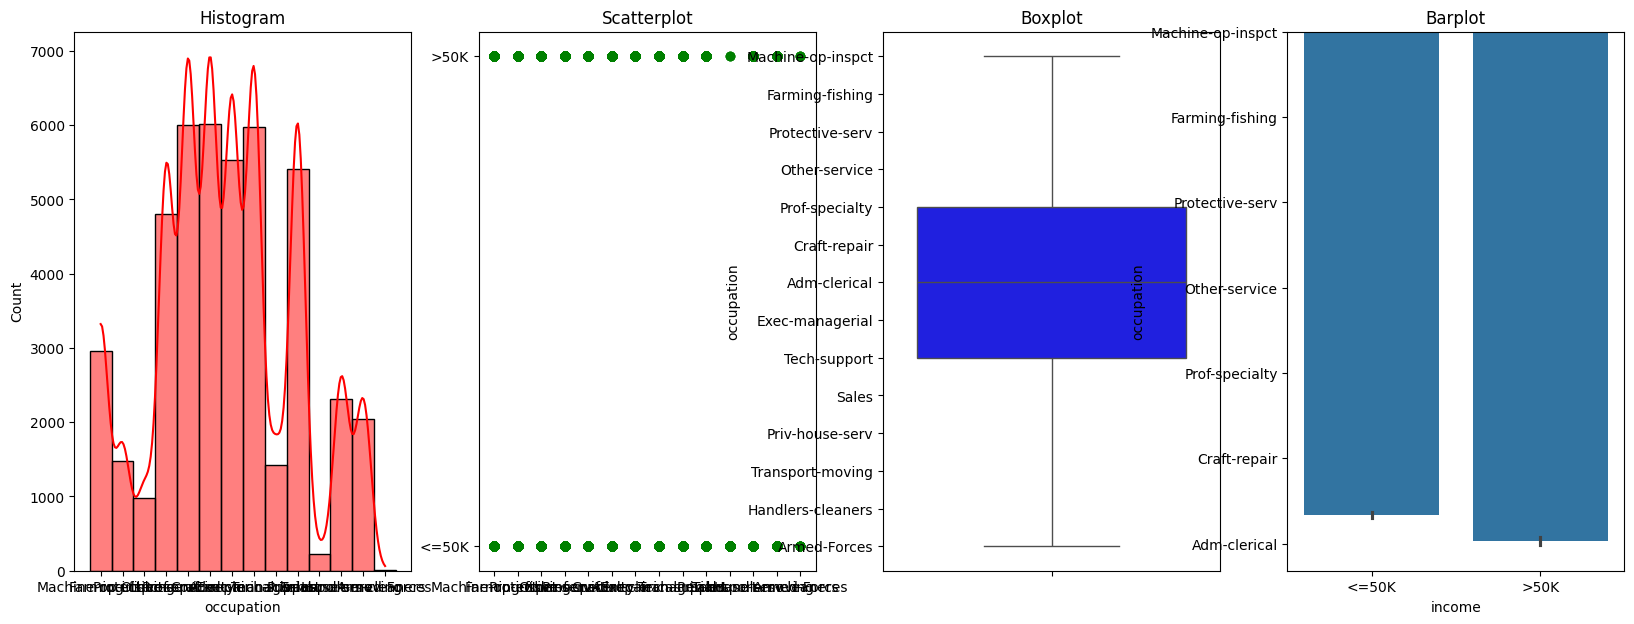

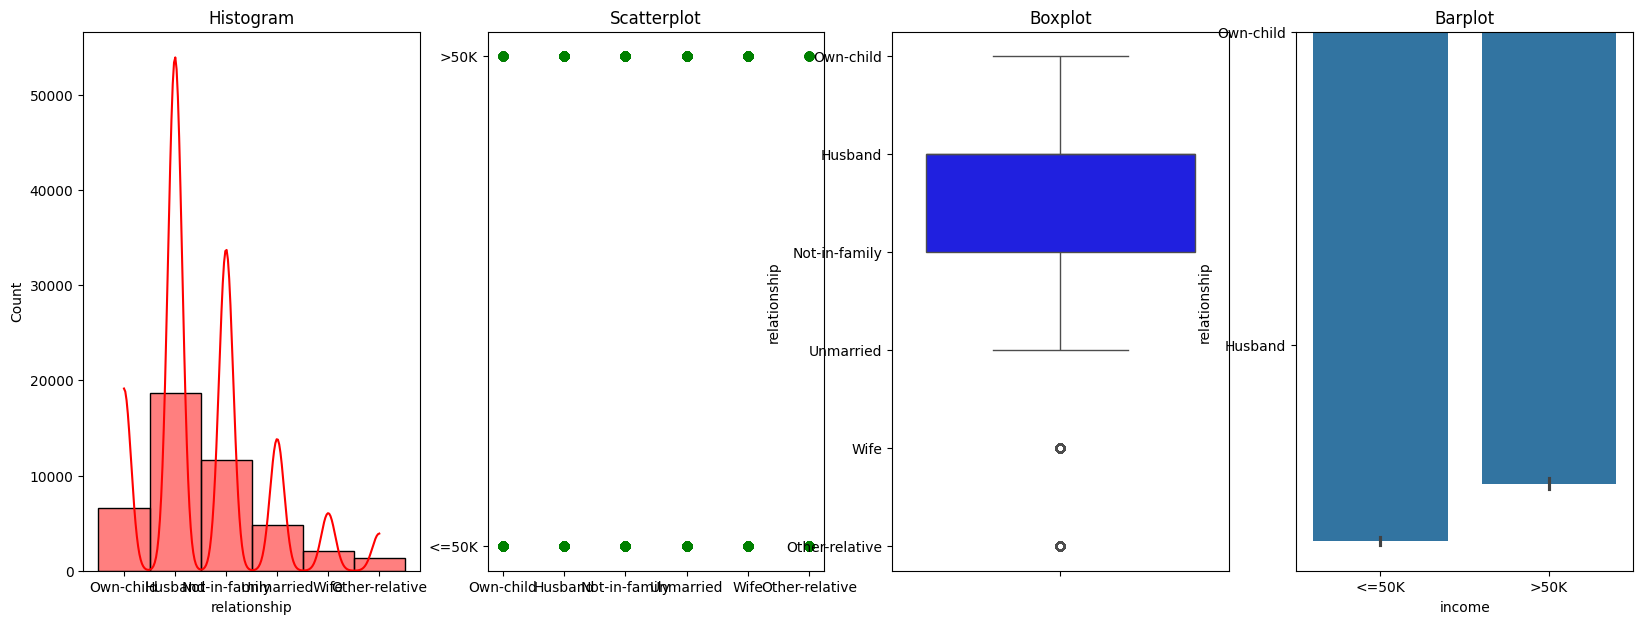

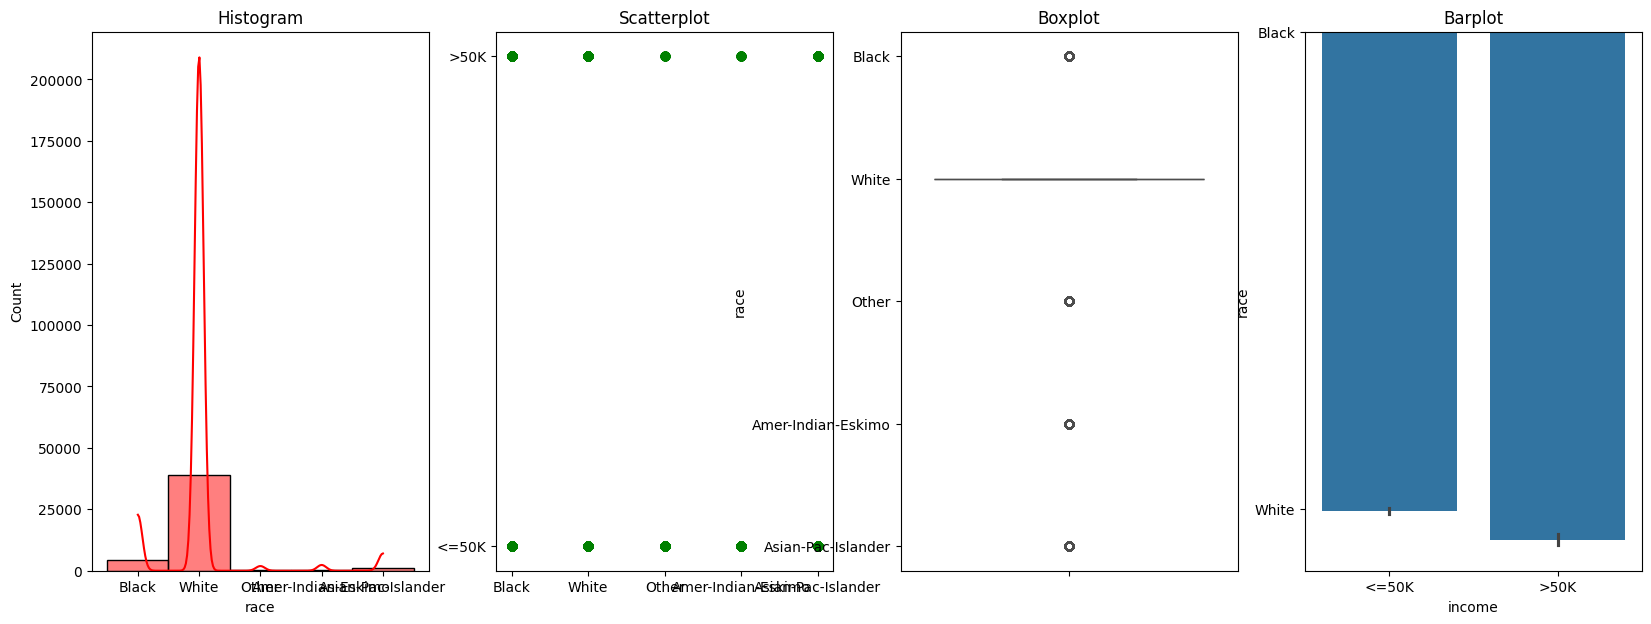

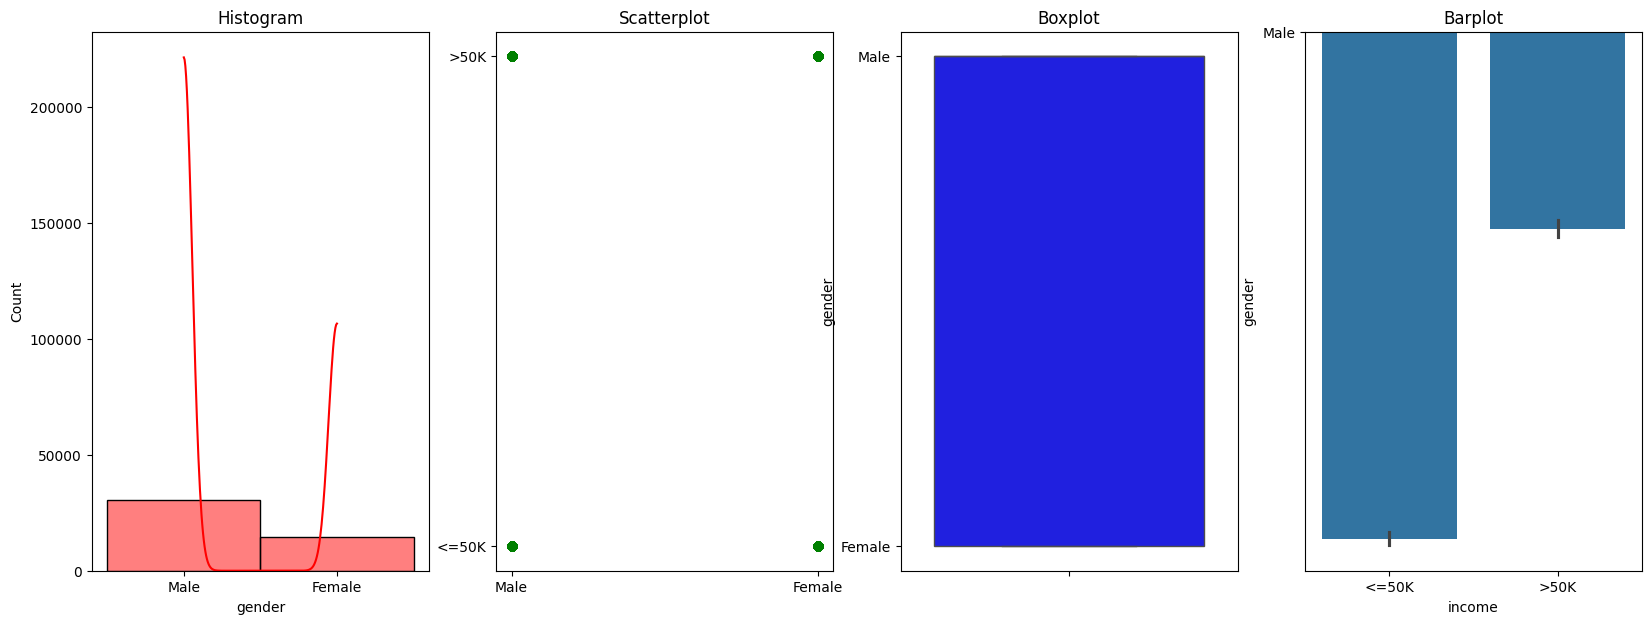

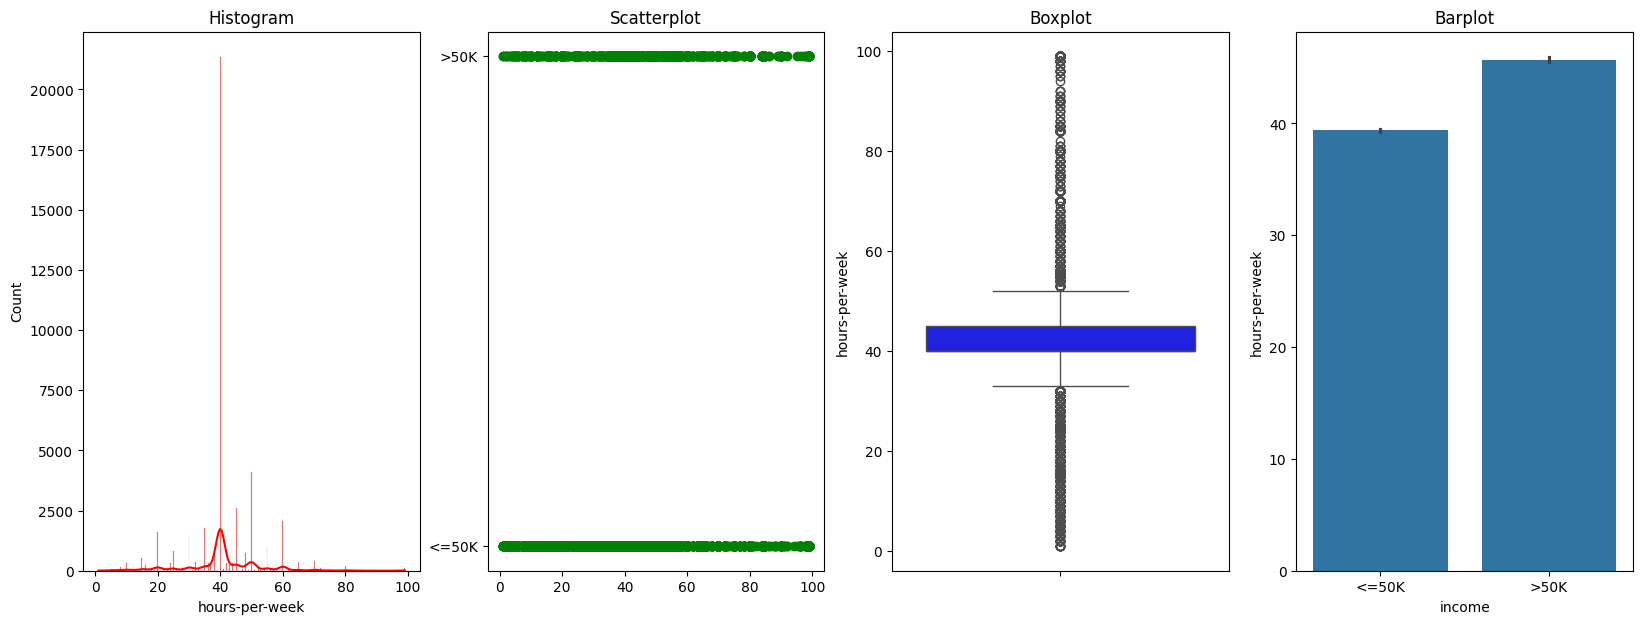

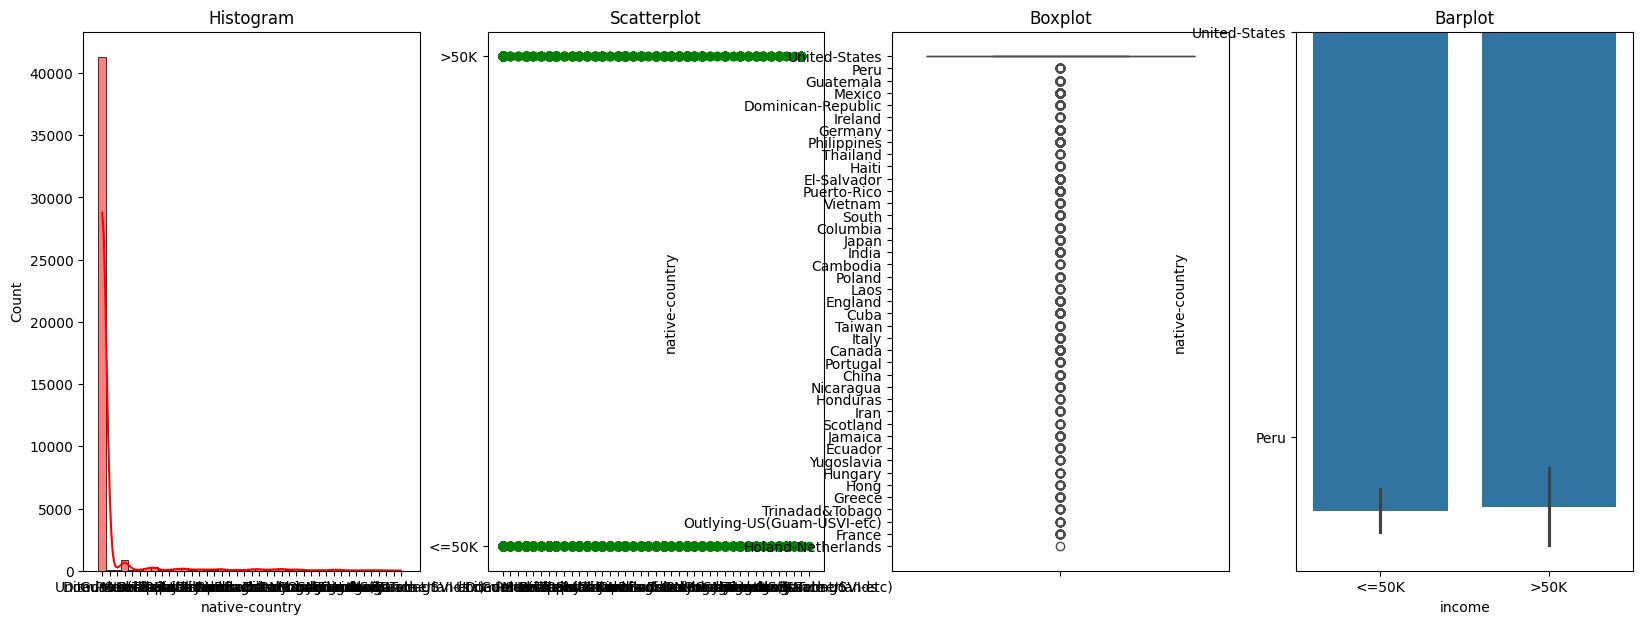

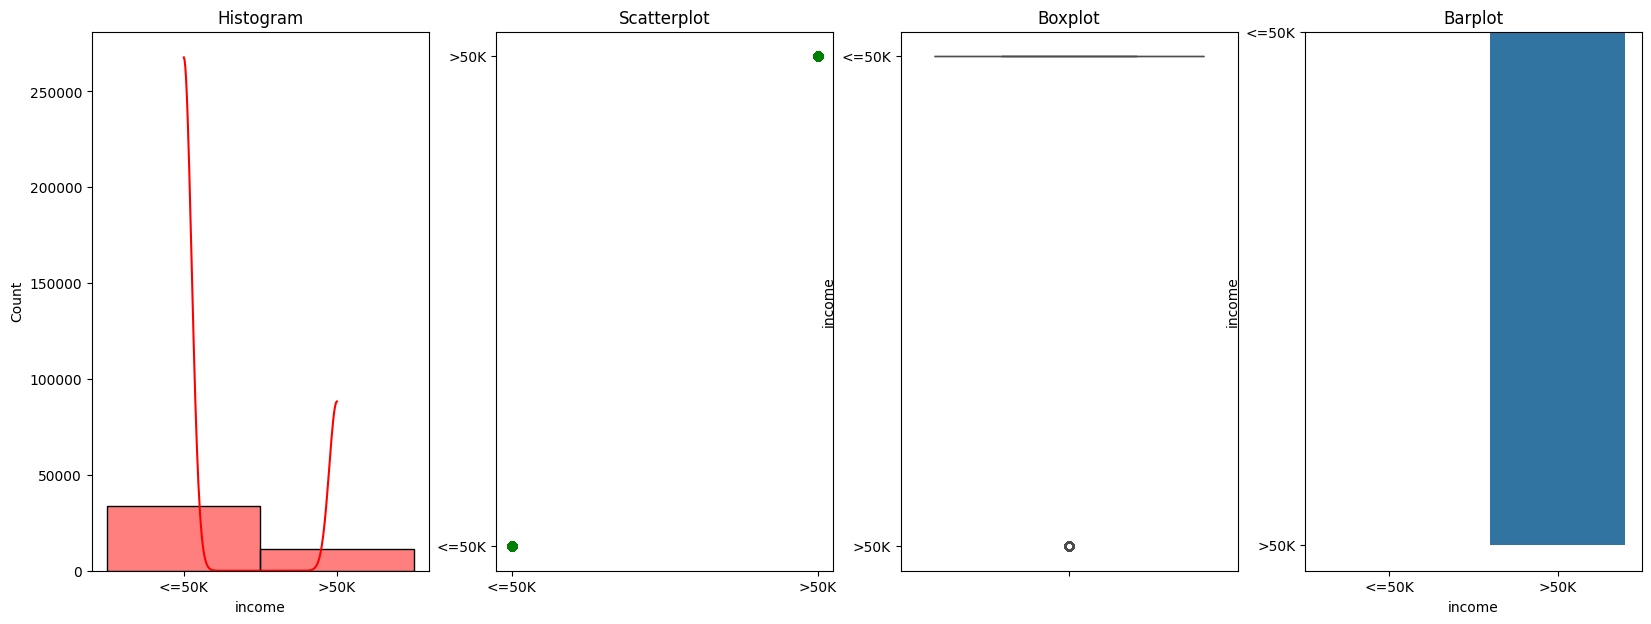

In [33]:
for col in df1:
    diagnostic_plots(df1,col,'income')

In [34]:
from sklearn.model_selection import train_test_split
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
# %%
# split Data
X = df1.drop(columns={"income"},axis=1)
y =df1["income"].values.reshape(-1,1) #target

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (40657, 11)
y_train shape: (40657, 1)
X_test shape: (4518, 11)
y_test shape: (4518, 1)


In [36]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming 'df1' contains both numeric and categorical features
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
numerical_features = [col for col in df1.columns if col not in categorical_features and col != 'income']

# Create a ColumnTransformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),  # Use OneHotEncoder for categorical features
    ])

# Apply the preprocessor to your training and testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Accuracy : 0.8346613545816733


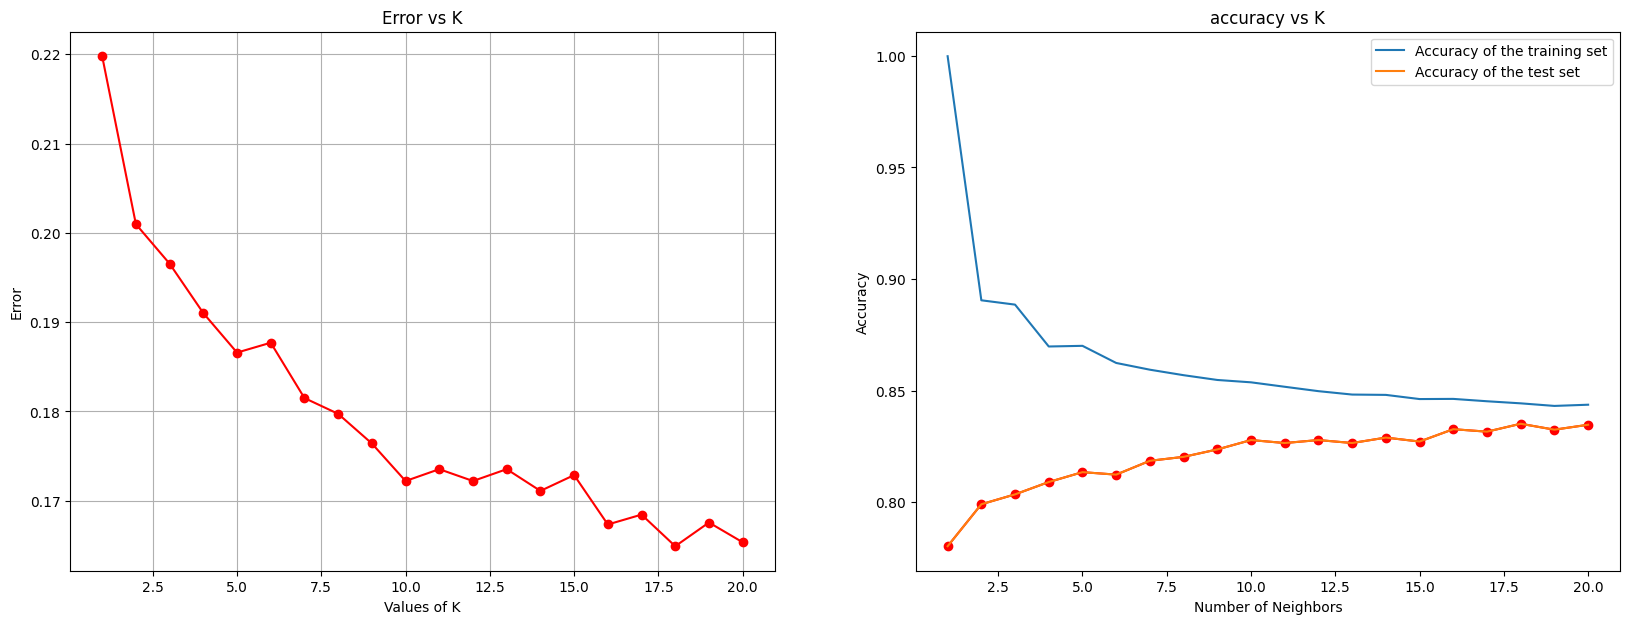

Fitting 10 folds for each of 29 candidates, totalling 290 fits


{'n_neighbors': 24}

In [37]:
# %%
#Find Best K
K = 20
error =[]
accuracy=[]
for i in range(1,K+1):
    knn= KNeighborsClassifier(n_neighbors= i)
    knn.fit(X_train,y_train)
    y_pred =knn.predict(X_test)
    error.append(1-metrics.accuracy_score(y_test,y_pred))
    accuracy.append(metrics.accuracy_score(y_test,y_pred))

# Visualazitation
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),error,'r-',marker='o')
plt.xlabel('Values of K')
plt.ylabel('Error')
plt.grid()
plt.title('Error vs K')

plt.subplot(1, 2, 2)
plt.plot(range(1,21),accuracy,'r-',marker='o')
plt.xlabel('Values of K')
plt.ylabel('accuracy')
plt.grid()
plt.title('accuracy vs K')
# %%
K=20
clf= KNeighborsClassifier(K)
clf.fit(X_train,y_train)
y_pred =clf.predict(X_test)
print("Accuracy :" ,metrics.accuracy_score(y_test,y_pred))
# %%
#Find Best K
training_acc = []
test_acc = []

# try KNN for different K nearest neighbor from 1 to 30
neighbors_setting = range(1,21)
for n_neighbors in neighbors_setting:
    knn= KNeighborsClassifier(n_neighbors= n_neighbors, )
    knn.fit(X_train,y_train.ravel())
    training_acc.append(knn.score(X_train,y_train))
    test_acc.append(knn.score(X_test,y_test))

plt.plot(neighbors_setting,training_acc,label='Accuracy of the training set')
plt.plot(neighbors_setting,test_acc,label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.grid()
plt.legend()
plt.show()
# %%
#Find Best K

parameters = {"n_neighbors":range(1,30)}
grid_kn=GridSearchCV(estimator=knn,#model
                     param_grid=parameters, #range of K
                    scoring='accuracy',# Strategy to evaluate the performance of the cross-validation model on the test set.
                    cv= 10, # Cross-validation generator
                    verbose= 1, #Time to calculate
                    n_jobs= -1 #Help to cpu
                    )
grid_kn.fit(X_train,y_train.ravel())
# %%
grid_kn.best_params_


In [38]:
#Zero-Knowledge Neural Architecture/Algorithm
import tenseal as ts
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

def load_and_preprocess_data(dataset_path): # Add dataset_path as an argument
    # Load dataset from a CSV file (replace with your file path)
    data = pd.read_csv(dataset_path) # Replace with the correct path to your dataset


    # Handle missing values by filling with the mode (for categorical columns)
    data = data.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

    # Encode categorical columns using LabelEncoder
    label_encoders = {}
    categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store the encoder for later use

    # Feature columns (X)
    X = data.drop(columns=['income'])

    # Target column (y)
    y = data['income'].map({'<=50K': 0, '>50K': 1})

    # Normalize feature data (StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [39]:
# Step 2: Encrypt the data using Tenseal (homomorphic encryption)
def init_encryption():
    context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.generate_galois_keys()
    context.global_scale = pow(2, 40)
    return context

context = init_encryption()

# Load and preprocess dataset
dataset_path = "/root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2/adult.csv" # Assuming this is the correct path
X, y = load_and_preprocess_data(dataset_path)

# Encrypt the data (convert each row into a vector and encrypt it)
encrypted_X = [ts.ckks_vector(context, row) for row in X]

In [40]:
# Step 3: KNN algorithm to find nearest neighbors (working on encrypted data)
def encrypted_euclidean_distance(vec1, vec2):
    """
    Calculate Euclidean distance between two encrypted vectors.
    Homomorphic encryption ensures the calculation is done without decrypting the data.
    """
    diff = vec1 - vec2  # Subtraction of two encrypted vectors
    squared_diff = diff * diff  # Element-wise square
    return squared_diff.sum().decrypt()  # Decrypt the result to calculate sum

def encrypted_knn(X_train_encrypted, X_query_encrypted, y_train, k=3):
    """
    Perform encrypted KNN prediction.
    """
    distances = []

    # Calculate the distance from the query point to all training points
    for train_point in X_train_encrypted:
        dist = encrypted_euclidean_distance(train_point, X_query_encrypted)
        distances.append(dist)

    # Sort the distances to find the nearest neighbors (smallest distances)
    k_nearest_neighbors = np.argsort(distances)[:k]

    # Get the labels of the k nearest neighbors
    neighbors_labels = y_train.iloc[k_nearest_neighbors.flatten()]  # Use iloc with flattened indices

    # Majority voting: the predicted label is the most common among the nearest neighbors
    prediction = np.bincount(neighbors_labels).argmax()

    return prediction

In [41]:
# Step 4: Zero-Knowledge Proofs (ZKP) for model output validation
# Replace with actual zk-SNARKs library and proof generation methods for real-world applications

class ZKProof:
    @staticmethod
    def generate(X_query, X_train, y_train, model_output):
        """
        Simulates ZKP generation using hashing.
        """
        # 1. Simulate Circuit Representation (using hashing)
        combined_data = str(X_query) + str(X_train) + str(y_train)
        circuit_hash = hashlib.sha256(combined_data.encode()).hexdigest()

        # 2. Simulate Witness Generation (using compression)
        witness = snappy.compress(combined_data.encode())

        # 3. Simulate Proof Generation (combining hash and witness)
        proof = (circuit_hash, witness)

        return {"proof": proof, "prediction": model_output}

        return {"proof": "zk_proof_placeholder", "prediction": model_output}

    @staticmethod
    def verify(proof, X_query, model_output):
        """
        Simulates ZKP verification using hashing.
        """
        circuit_hash, witness = proof["proof"]

        # 1. Reconstruct combined data from witness
        combined_data = snappy.uncompress(witness).decode()

        # 2. Recalculate circuit hash
        recalculated_hash = hashlib.sha256(combined_data.encode()).hexdigest()

        # 3. Verify if hashes match
        is_valid = circuit_hash == recalculated_hash

        print(f"Verifying proof for prediction: {model_output}")
        print(f"Proof valid: {is_valid}")

        return is_valid


In [42]:
# Main execution
if __name__ == "__main__":
    dataset_path = "/root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2/adult.csv"
    X, y = load_and_preprocess_data(dataset_path)
    context = init_encryption()

    # Encrypt the data for KNN
    encrypted_X = [ts.ckks_vector(context, row) for row in X]

    # Step 5: Making a prediction
    X_query = np.zeros(X.shape[1]) # This line should have 4 spaces of indentation
    X_query[0] = 55  # Feature 1: age
    X_query[1] = 2000  # Feature 2: capital-gain
    X_query[2] = 0  # Feature 3: capital-loss
    # ... set other features as needed ...

    encrypted_X_query = ts.ckks_vector(context, X_query)

    prediction = encrypted_knn(encrypted_X, encrypted_X_query, y, k=3)
    proof = ZKProof.generate(X_query, X, y, prediction)

    if ZKProof.verify(proof, X_query, prediction):
        print(f"Prediction validated: {prediction}")
    else:
        print("Invalid prediction")

Verifying proof for prediction: 0
Proof valid: True
Prediction validated: 0
